In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# url = 'https://en.wikipedia.org/wiki/FTSE_100_Index'
# tables = pd.read_html(url)

# ftse100_df = tables[6]
# tickers = ftse100_df['Ticker'].tolist()
# tickers = [ticker + '.L' for ticker in tickers]  # Yahoo Finance suffix for London Stock Exchange

In [3]:
import pandas as pd
import requests

url = 'https://en.wikipedia.org/wiki/FTSE_100_Index'

# Define a User-Agent header to mimic a web browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.60 Safari/537.36'
}

# Make the request with the headers
try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # This will raise an HTTPError for bad responses (4xx or 5xx)
    
    # Pass the content of the response to pandas
    tables = pd.read_html(response.text)
    
    ftse100_df = tables[6]
    tickers = ftse100_df['Ticker'].tolist()
    tickers = [ticker + '.L' for ticker in tickers]  # Yahoo Finance suffix for London Stock Exchange

    print(f"Number of tickers found: {len(tickers)}")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

Number of tickers found: 100


In [4]:
# Fetch historical data (e.g., 5 years of daily data)
data = yf.download(tickers, start="2020-01-01", end="2024-12-31", group_by='ticker')

[*********************100%***********************]  100 of 100 completed


In [5]:
data.head()

Ticker           PCT.L                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2020-01-02  160.000000  161.000000  158.983002  161.000000  1331440   
2020-01-03  160.600006  161.895996  159.399994  161.800003  1993890   
2020-01-06  161.000000  161.785995  158.800003  159.600006  2084330   
2020-01-07  160.800003  161.416000  159.250000  161.000000  1764400   
2020-01-08  159.000000  161.587006  159.000000  160.600006  1300900   

Ticker           WEIR.L                                                 ...  \
Price              Open         High          Low        Close  Volume  ...   
Date                                                                    ...   
2020-01-02  1515.408685  1537.892493  1510.412283  1515.908325  670870  ...   
2020-01-03  1530.897713  1530.897713  1485.930091  1511.411743  823346  ...   
2020-01-06  1474.937980  1511.911358  1474.937980  1503.917114  863968  ...   
2020-01-07  1491.426217  1523.403194  1491.426217  1504.916504  635662  ...   
2020-01-08  1503.917301  1506.915143  1479.934567  1498.920898  810443  ...   

Ticker          CNA.L                                                 HSBA.L  \
Price            Open       High        Low      Close    Volume        Open   
Date                                                                           
2020-01-02  89.199093  90.987472  89.199093  90.078300  13052028  587.341759   
2020-01-03  89.119164  90.537883  88.879383  90.398010  12610758  590.831766   
2020-01-06  89.998364  90.118251  88.950311  89.498817  15219431  588.338903   
2020-01-07  90.837599  90.837599  87.580559  87.580559  15522301  586.244899   
2020-01-08  86.921157  88.439776  86.921157  88.140053  12537798  578.865534   

Ticker                                                    
Price             High         Low       Close    Volume  
Date                                                      
2020-01-02  596.316420  587.042615  593.424561  17220449  
2020-01-03  600.330945  585.147802  592.726440  16976787  
2020-01-06  590.782017  579.164793  583.552429  18984368  
2020-01-07  586.344594  580.959772  581.757568  14960529  
2020-01-08  580.959597  574.677347  579.663269  20405597  

[5 rows x 500 columns]

In [6]:
# Step 1: Calculate Mid prices for each ticker
mid_prices = pd.concat([
    ((data[ticker]['Open'] + data[ticker]['Close']) / 2).rename(ticker)
    for ticker in tickers
], axis=1)

# Step 2: Drop rows with missing values (optional)
mid_prices = mid_prices.dropna()

In [7]:
mid_prices.head()

III.L        ADM.L       AAF.L       ALW.L        AAL.L  \
Date                                                                        
2022-07-18  1193.616059  1770.288384  158.555060  930.801977  2574.943717   
2022-07-19  1189.619075  1732.080647  162.050759  929.303141  2552.170371   
2022-07-20  1200.361113  1734.577923  163.998356  942.793089  2583.270673   
2022-07-21  1223.593800  1744.566764  165.945963  952.785450  2563.434680   
2022-07-22  1244.578550  1741.819725  165.496514  953.285163  2591.841269   

                 ANTO.L        AHT.L        ABF.L         AZN.L      AUTO.L  \
Date                                                                          
2022-07-18  1028.609801  3871.105040  1611.763615  11140.144020  584.318380   
2022-07-19  1029.859072  3887.594268  1639.992147  11113.164148  586.617211   
2022-07-20  1053.344424  4023.010704  1673.716288  11072.193479  597.711911   
2022-07-21  1043.350743  4103.461353  1692.451872  10782.395397  609.006414   
2022-07-22  1064.087807  4159.926055  1692.951516  10762.410267  613.304445   

            ...        STJ.L        TW.L      TSCO.L       ULVR.L  \
Date        ...                                                     
2022-07-18  ...  1151.496644  118.416243  259.682220  3875.866316   
2022-07-19  ...  1154.743272  119.438792  260.281512  3891.598267   
2022-07-20  ...  1164.982199  121.334258  261.230313  3911.575576   
2022-07-21  ...  1171.225381  124.177429  260.081742  3888.601193   
2022-07-22  ...  1182.712879  125.474332  259.832061  3906.581620   

                   UU.L        UTG.L       VOD.L       WEIR.L        WTB.L  \
Date                                                                         
2022-07-18  1026.843563  1151.705520  129.199171  1385.705169  2643.169258   
2022-07-19  1044.819043  1155.201584  130.067017  1392.201491  2647.665252   
2022-07-20  1051.060426  1166.189358  130.096934  1414.438670  2689.628132   
2022-07-21  1057.301904  1170.184887  128.690434  1465.159637  2679.137371   
2022-07-22  1066.788897  1196.655002  128.750265  1492.144176  2674.142263   

                 WPP.L  
Date                    
2022-07-18  805.614169  
2022-07-19  820.790069  
2022-07-20  851.041629  
2022-07-21  863.821265  
2022-07-22  864.919578  

[5 rows x 100 columns]

In [8]:
# Step 3: Transpose so that each row is a ticker and columns are dates
data_for_clustering = mid_prices.T.copy()

data_for_clustering.head()

Date    2022-07-18   2022-07-19   2022-07-20   2022-07-21   2022-07-22  \
III.L  1193.616059  1189.619075  1200.361113  1223.593800  1244.578550   
ADM.L  1770.288384  1732.080647  1734.577923  1744.566764  1741.819725   
AAF.L   158.555060   162.050759   163.998356   165.945963   165.496514   
ALW.L   930.801977   929.303141   942.793089   952.785450   953.285163   
AAL.L  2574.943717  2552.170371  2583.270673  2563.434680  2591.841269   

Date    2022-07-25   2022-07-26   2022-07-27   2022-07-28   2022-07-29  ...  \
III.L  1227.091545  1213.601346  1214.100990  1239.332258  1262.315293  ...   
ADM.L  1733.329264  1759.050816  1803.501433  1858.190840  1901.392882  ...   
AAF.L   166.445350   170.340590   171.489145   165.446595   158.405237  ...   
ALW.L   957.282108   942.293396   945.790743   961.279134   970.772120  ...   
AAL.L  2634.695461  2698.610025  2703.507483  2785.298757  2861.946851  ...   

Date    2024-12-10   2024-12-12   2024-12-13   2024-12-18   2024-12-19  \
III.L  3634.626814  3632.127043  3639.126400  3640.626273  3564.634047   
ADM.L  2669.768238  2646.774687  2639.776439  2611.784197  2603.786295   
AAF.L   106.382556   106.132595   106.982454   106.332565   104.882798   
ALW.L  1278.785721  1278.785721  1280.785357  1252.790053  1242.791672   
AAL.L  2454.477706  2491.503322  2441.236821  2378.465032  2311.524568   

Date    2024-12-20   2024-12-23   2024-12-24   2024-12-27   2024-12-30  
III.L  3537.636769  3540.136601  3575.633081  3596.130808  3580.132620  
ADM.L  2595.788467  2605.286032  2625.780321  2619.782030  2614.283596  
AAF.L   104.682834   107.232414   110.381901   112.481552   113.381405  
ALW.L  1246.791121  1249.790590  1251.790314  1241.791964  1244.791370  
AAL.L  2285.778301  2286.759206  2314.957531  2298.529124  2287.249729  

[5 rows x 613 columns]

In [9]:
# Calculate percentage difference with respect to the first column (first date)
df_pct_diff = ((data_for_clustering.T - data_for_clustering.T.iloc[0]) / data_for_clustering.T.iloc[0]) * 100

# Transpose back to original format: Tickers as rows, Dates as columns
df_pct_diff = df_pct_diff.T

# Optional: round values for better readability
df_pct_diff = df_pct_diff.round(2)


In [10]:
df_pct_diff.head()

Date   2022-07-18  2022-07-19  2022-07-20  2022-07-21  2022-07-22  2022-07-25  \
III.L         0.0       -0.33        0.57        2.51        4.27        2.80   
ADM.L         0.0       -2.16       -2.02       -1.45       -1.61       -2.09   
AAF.L         0.0        2.20        3.43        4.66        4.38        4.98   
ALW.L         0.0       -0.16        1.29        2.36        2.42        2.84   
AAL.L         0.0       -0.88        0.32       -0.45        0.66        2.32   

Date   2022-07-26  2022-07-27  2022-07-28  2022-07-29  ...  2024-12-10  \
III.L        1.67        1.72        3.83        5.76  ...      204.51   
ADM.L       -0.63        1.88        4.97        7.41  ...       50.81   
AAF.L        7.43        8.16        4.35       -0.09  ...      -32.90   
ALW.L        1.23        1.61        3.27        4.29  ...       37.39   
AAL.L        4.80        4.99        8.17       11.15  ...       -4.68   

Date   2024-12-12  2024-12-13  2024-12-18  2024-12-19  2024-12-20  2024-12-23  \
III.L      204.30      204.88      205.01      198.64      196.38      196.59   
ADM.L       49.51       49.12       47.53       47.08       46.63       47.17   
AAF.L      -33.06      -32.53      -32.94      -33.85      -33.98      -32.37   
ALW.L       37.39       37.60       34.59       33.52       33.95       34.27   
AAL.L       -3.24       -5.19       -7.63      -10.23      -11.23      -11.19   

Date   2024-12-24  2024-12-27  2024-12-30  
III.L      199.56      201.28      199.94  
ADM.L       48.33       47.99       47.68  
AAF.L      -30.38      -29.06      -28.49  
ALW.L       34.49       33.41       33.73  
AAL.L      -10.10      -10.73      -11.17  

[5 rows x 613 columns]

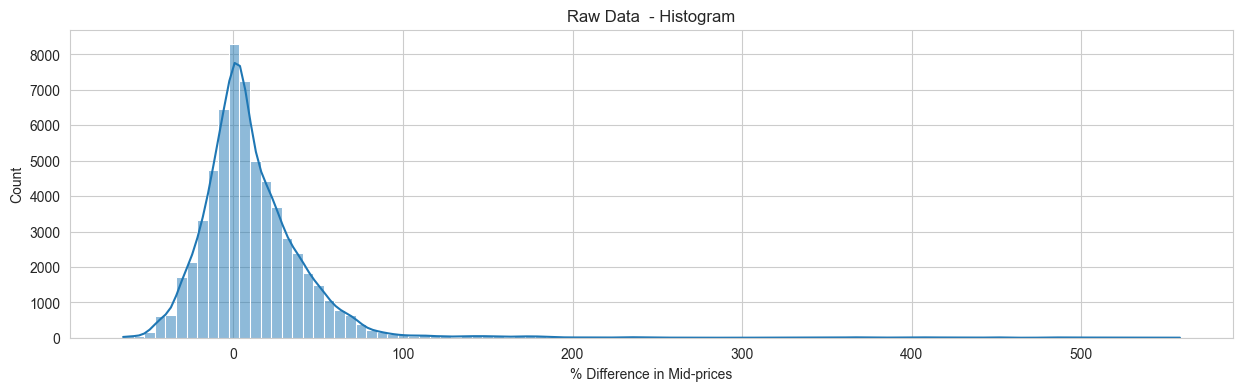

In [11]:
plt.figure(figsize=(15, 4))
sns.histplot(df_pct_diff.values.flatten(), bins=100, kde=True)
plt.title(f'{"Raw Data"}  - Histogram')
plt.xlabel("% Difference in Mid-prices")
plt.show()

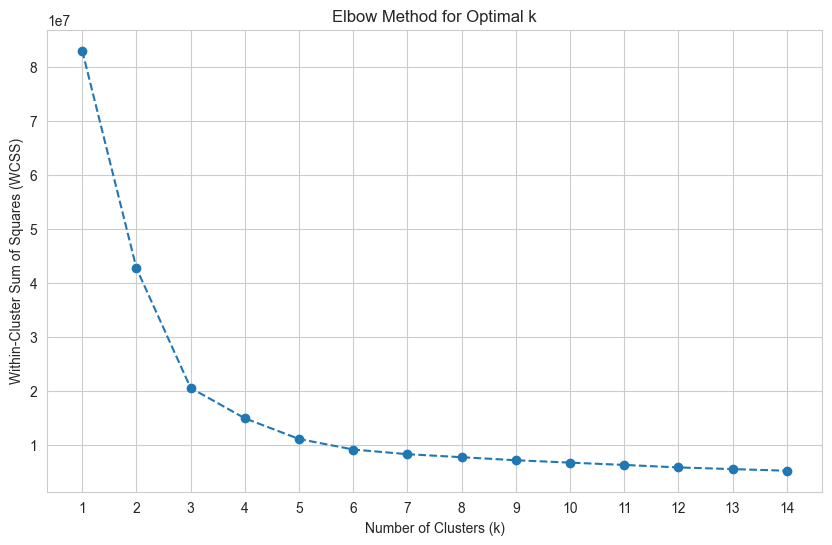

In [12]:
# Implement the Elbow Method
wcss = []  # Within-cluster sum of squares
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pct_diff)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.grid(True)

In [13]:
# Step 4: Clustering Algorithms
from sklearn.cluster import Birch

# Choose optimal k based on the elbow (assume 4 here)
optimal_k = 7

# Fit clustering models
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(df_pct_diff)
gmm = GaussianMixture(n_components=optimal_k, random_state=42).fit(df_pct_diff)
dbscan = DBSCAN(eps=2.5, min_samples=3).fit(df_pct_diff)
agglo = AgglomerativeClustering(n_clusters=optimal_k).fit(df_pct_diff)
birch = Birch(n_clusters=optimal_k).fit(df_pct_diff)

# Step 5: Evaluation Metrics
def evaluate_clustering(data, labels, name):
    if len(set(labels)) <= 1:
        print(f"{name} clustering resulted in 1 or fewer clusters. Skipping metrics.\n")
        return
    print(f"Results for {name}:")
    print(f"Silhouette Score (Higher is better): {silhouette_score(data, labels):.3f}")
    print(f"Davies-Bouldin Index (Lower is better): {davies_bouldin_score(data, labels):.3f}")
    print(f"Calinski-Harabasz Score (Higher is better): {calinski_harabasz_score(data, labels):.3f}\n")

evaluate_clustering(df_pct_diff, kmeans.labels_, "KMeans")
evaluate_clustering(df_pct_diff, gmm.predict(df_pct_diff), "GMM")
evaluate_clustering(df_pct_diff, dbscan.labels_, "DBSCAN")
evaluate_clustering(df_pct_diff, agglo.labels_, "Agglomerative")
evaluate_clustering(df_pct_diff, birch.labels_, "Birch")

# Step 6: Visualize stock trends by cluster
def plot_clusters_trend(df, labels, title_prefix):
    df_copy = df.copy()
    df_copy['Cluster'] = labels
    for cluster_id in sorted(df_copy['Cluster'].unique()):
        cluster_members = df_copy[df_copy['Cluster'] == cluster_id].drop(columns='Cluster')
        plt.figure(figsize=(14, 5))
        for i in range(len(cluster_members)):
            plt.plot(cluster_members.columns, cluster_members.iloc[i], alpha=0.4)
        plt.title(f"{title_prefix} - Cluster {cluster_id} Trends")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


Results for KMeans:
Silhouette Score (Higher is better): 0.228
Davies-Bouldin Index (Lower is better): 0.980
Calinski-Harabasz Score (Higher is better): 140.204

Results for GMM:
Silhouette Score (Higher is better): 0.228
Davies-Bouldin Index (Lower is better): 0.980
Calinski-Harabasz Score (Higher is better): 140.204

DBSCAN clustering resulted in 1 or fewer clusters. Skipping metrics.

Results for Agglomerative:
Silhouette Score (Higher is better): 0.209
Davies-Bouldin Index (Lower is better): 1.024
Calinski-Harabasz Score (Higher is better): 132.598

Results for Birch:
Silhouette Score (Higher is better): 0.209
Davies-Bouldin Index (Lower is better): 1.024
Calinski-Harabasz Score (Higher is better): 132.598



# KMeans

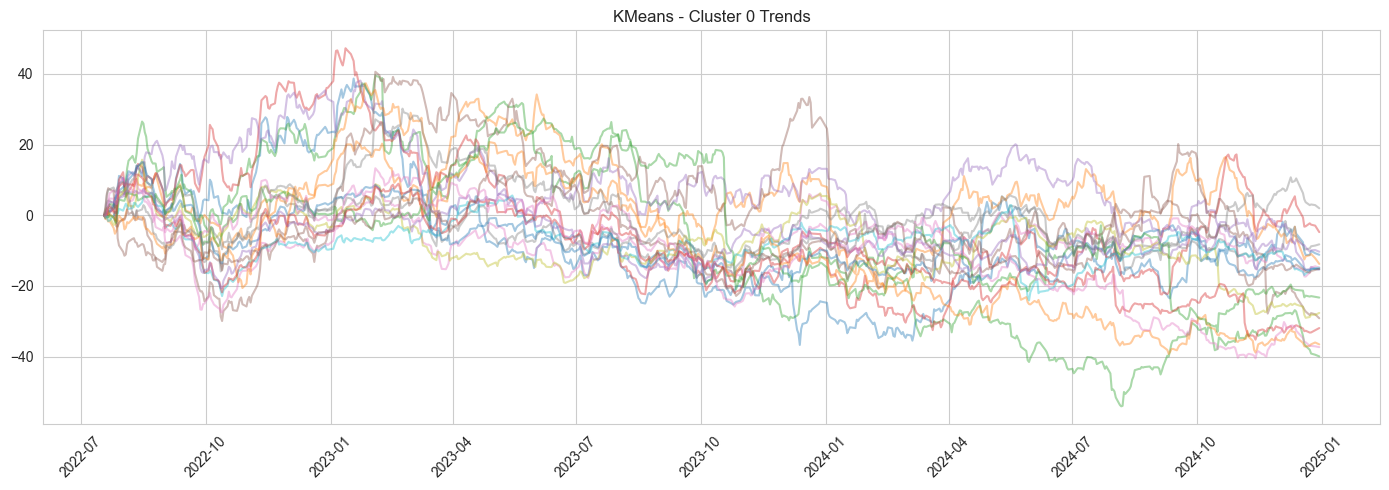

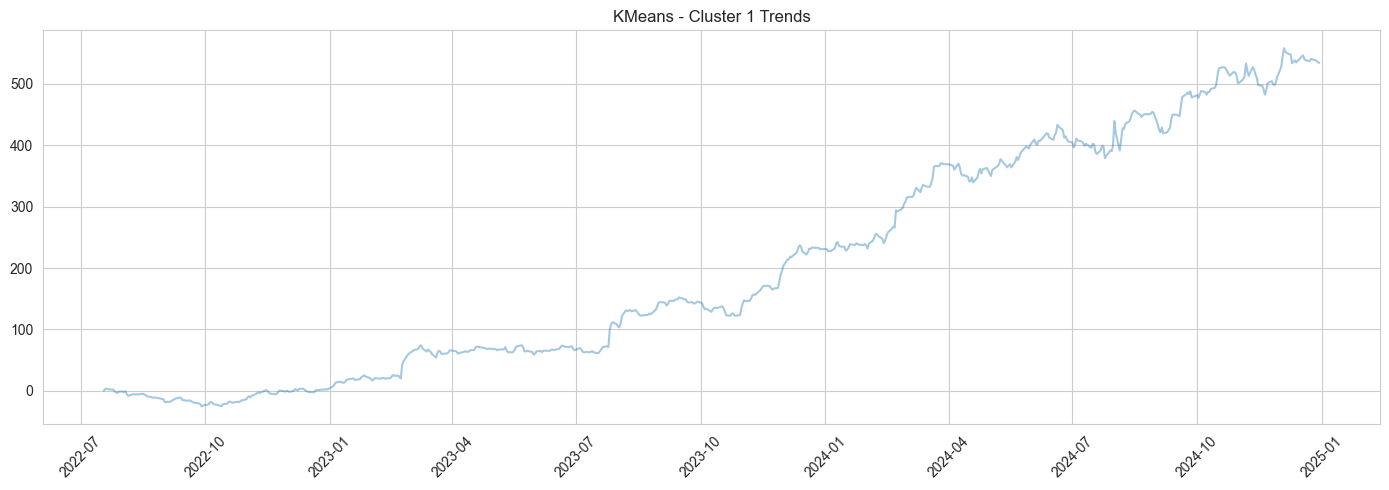

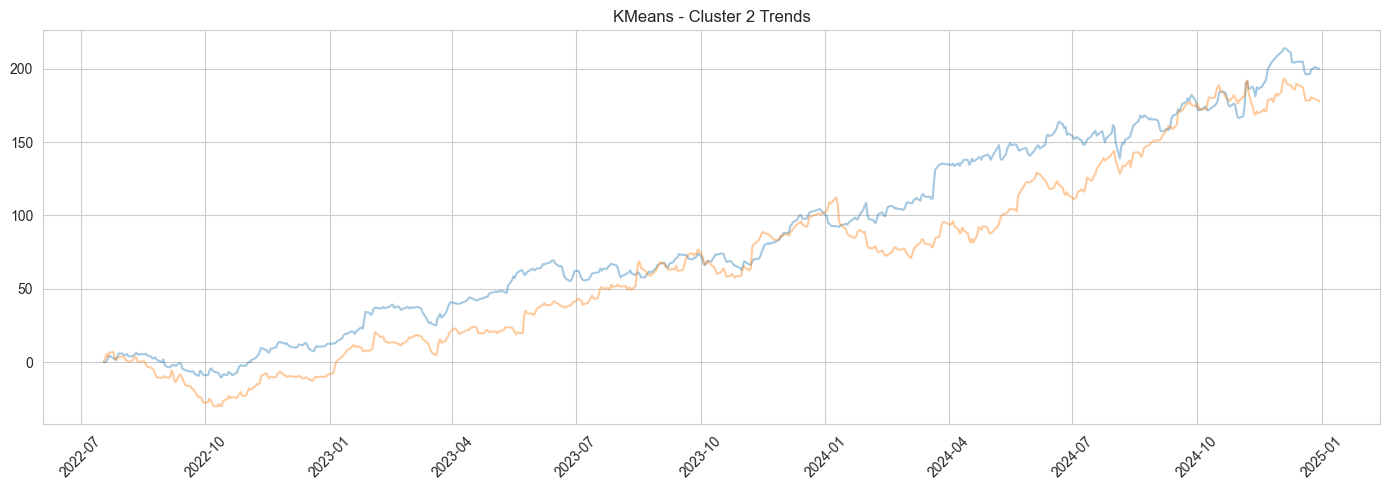

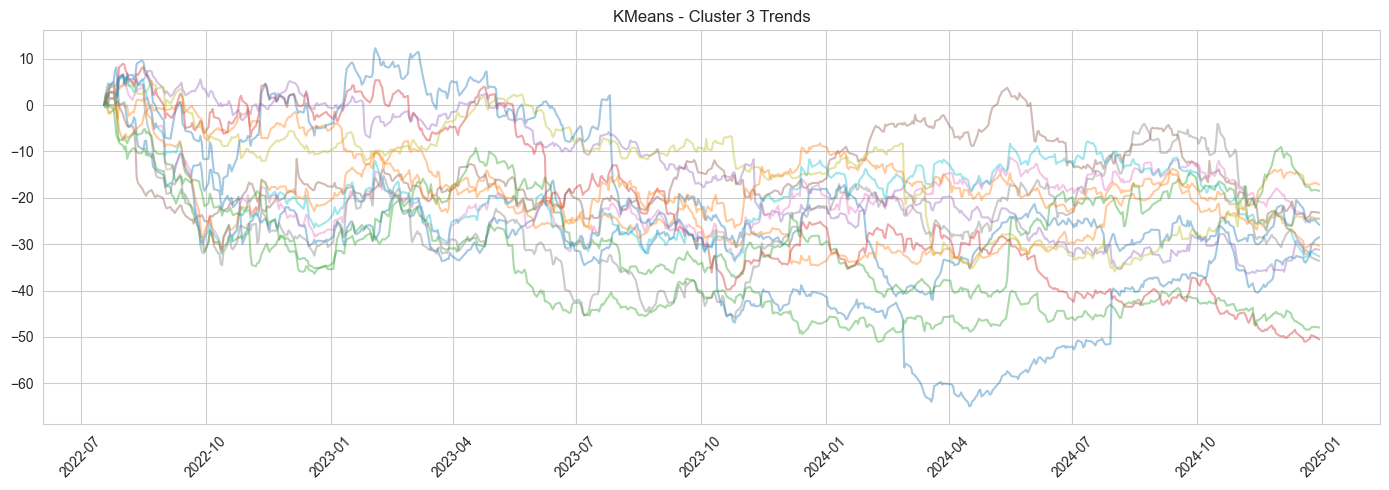

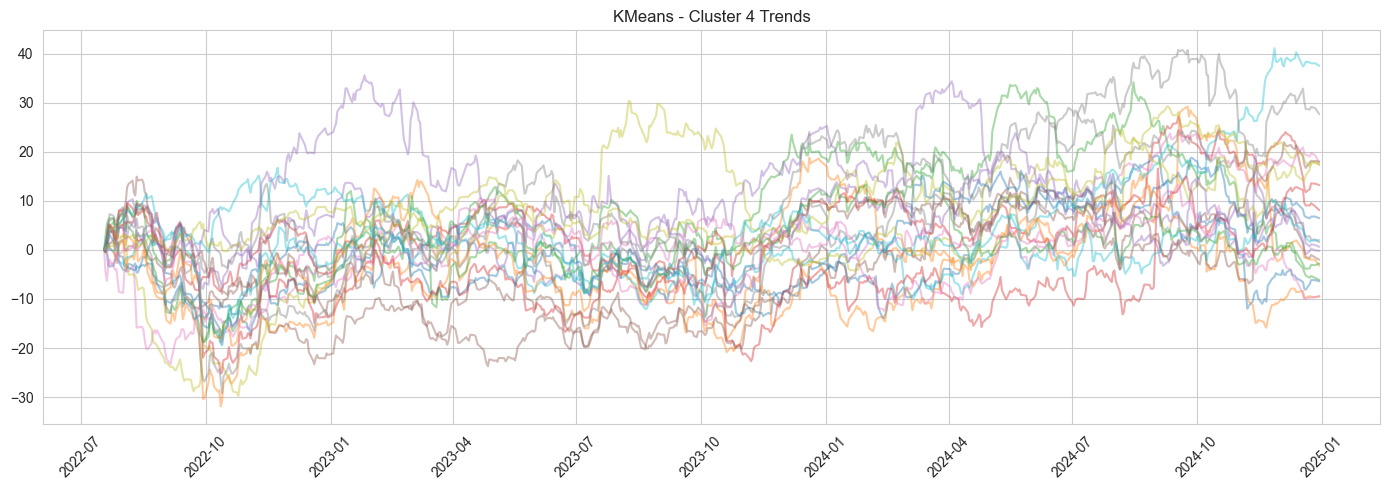

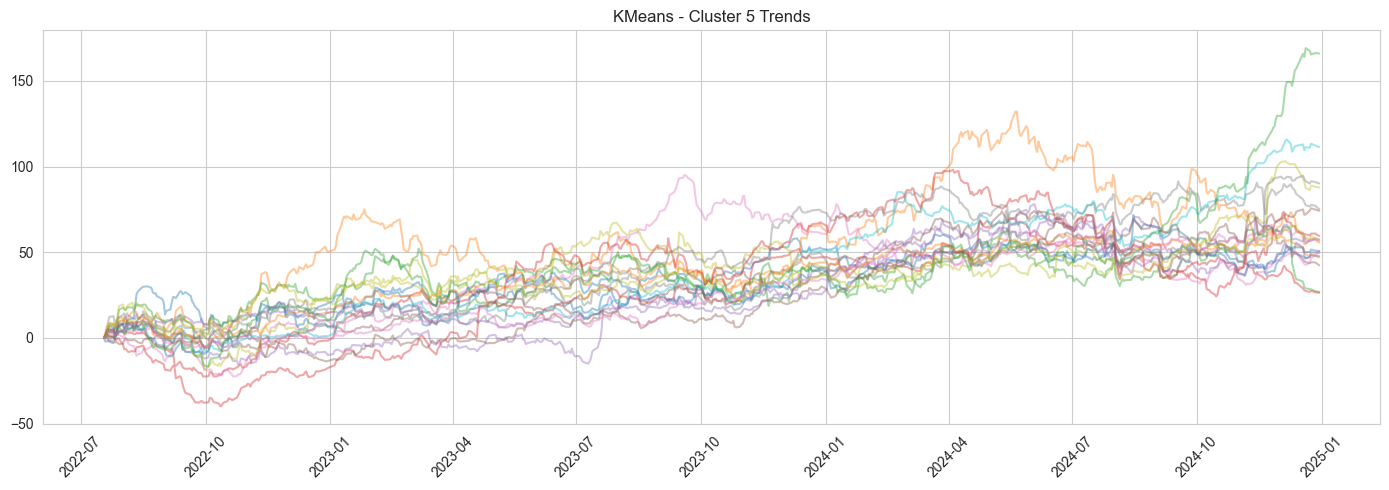

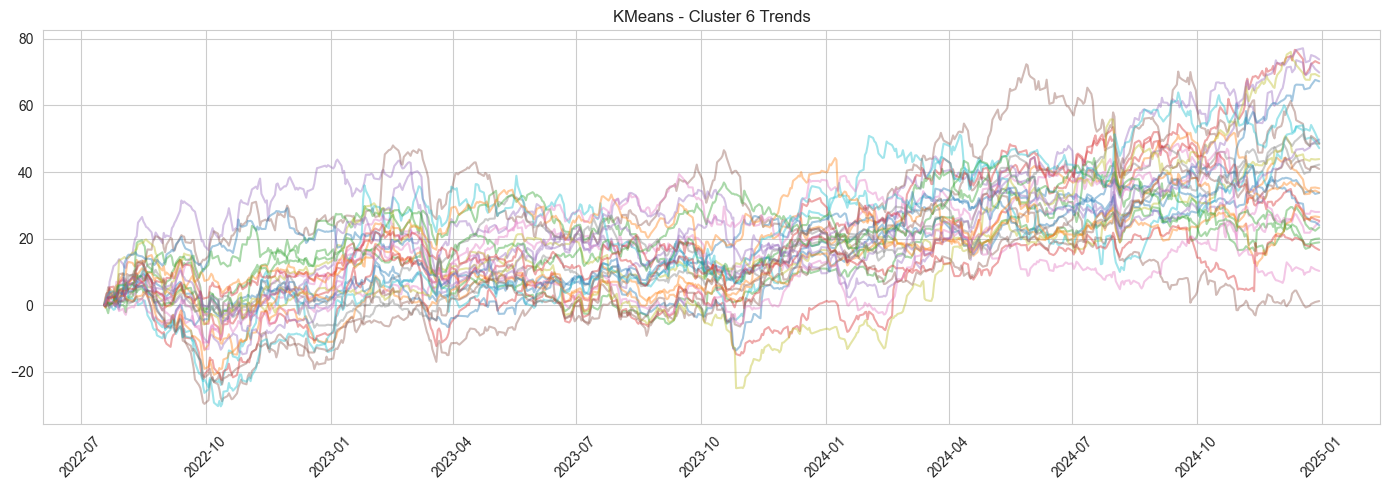

In [14]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df_pct_diff, kmeans.labels_, "KMeans")

# Agglo

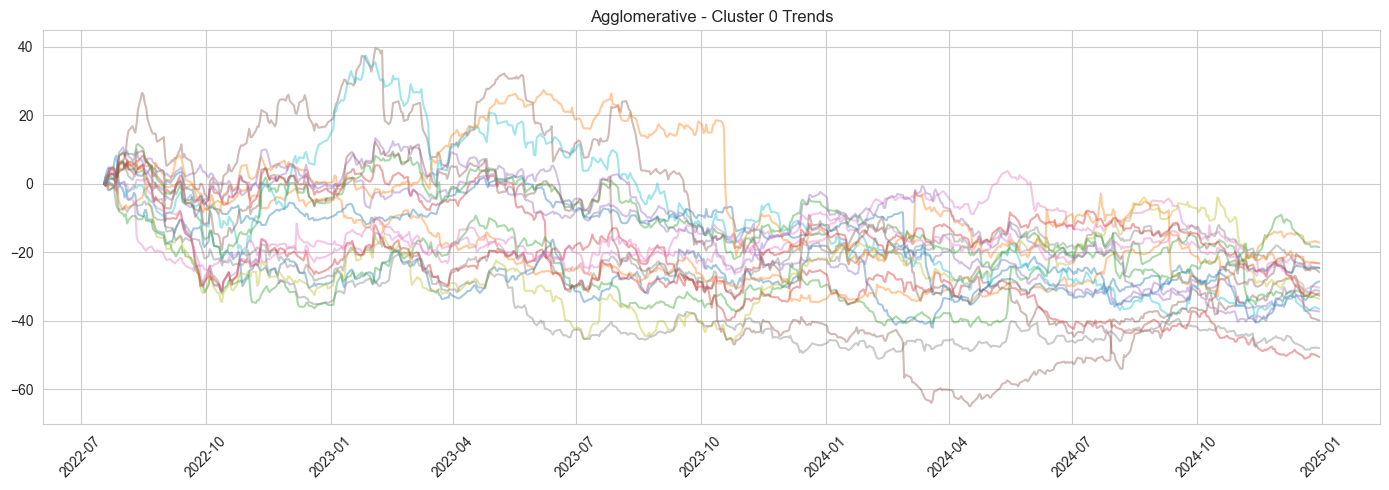

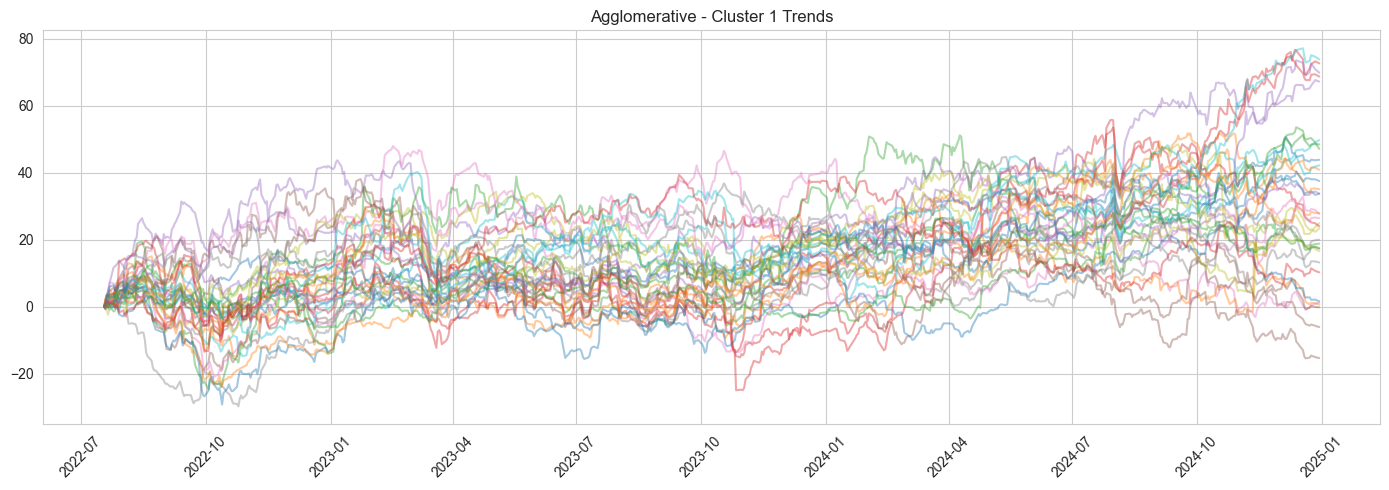

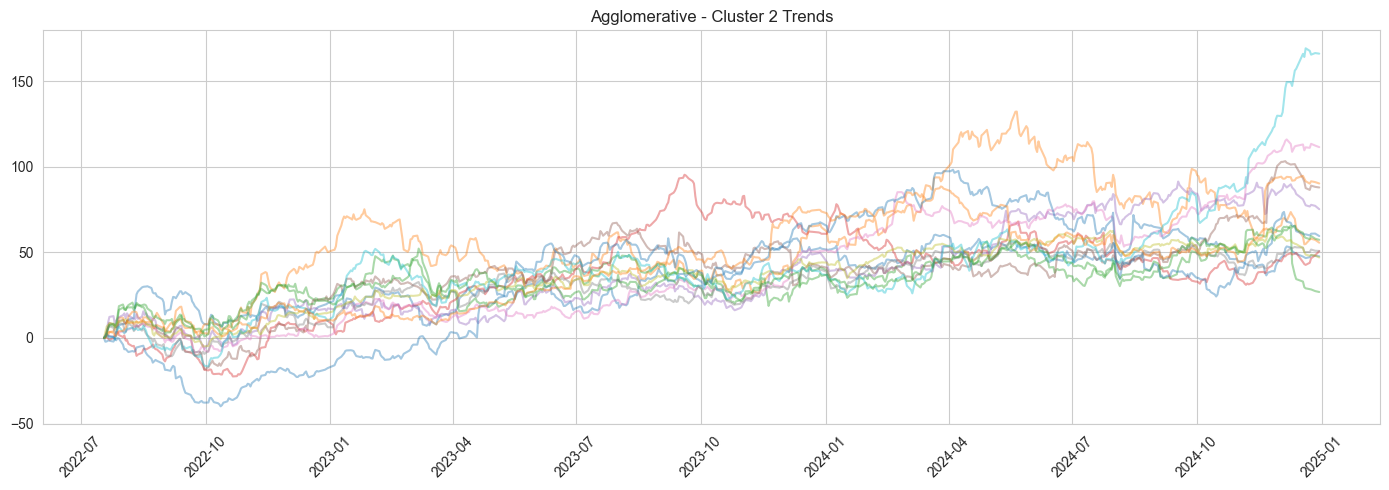

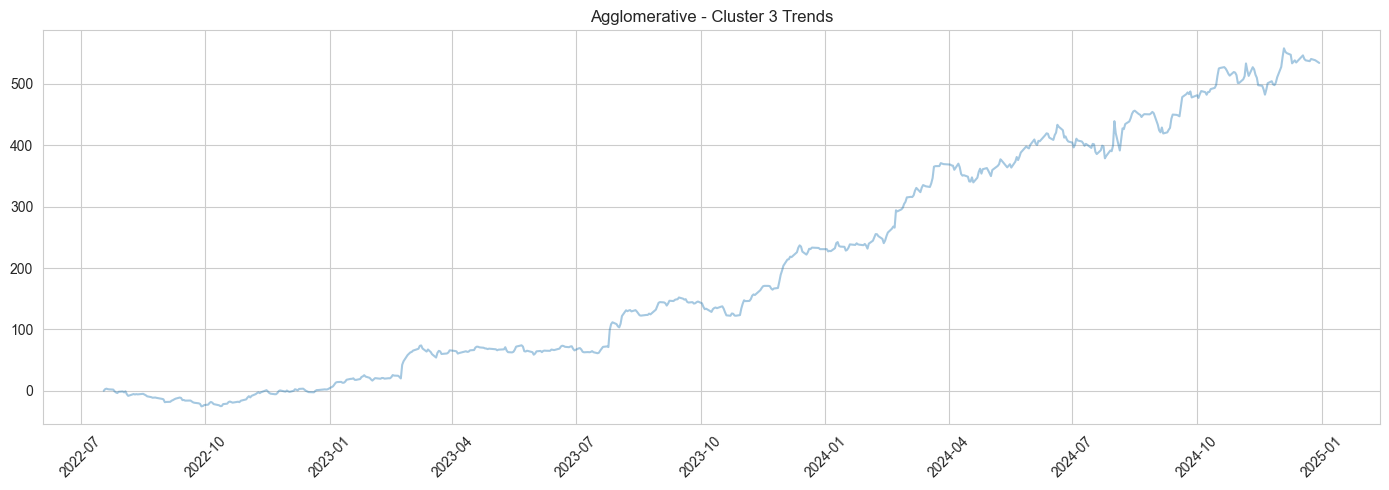

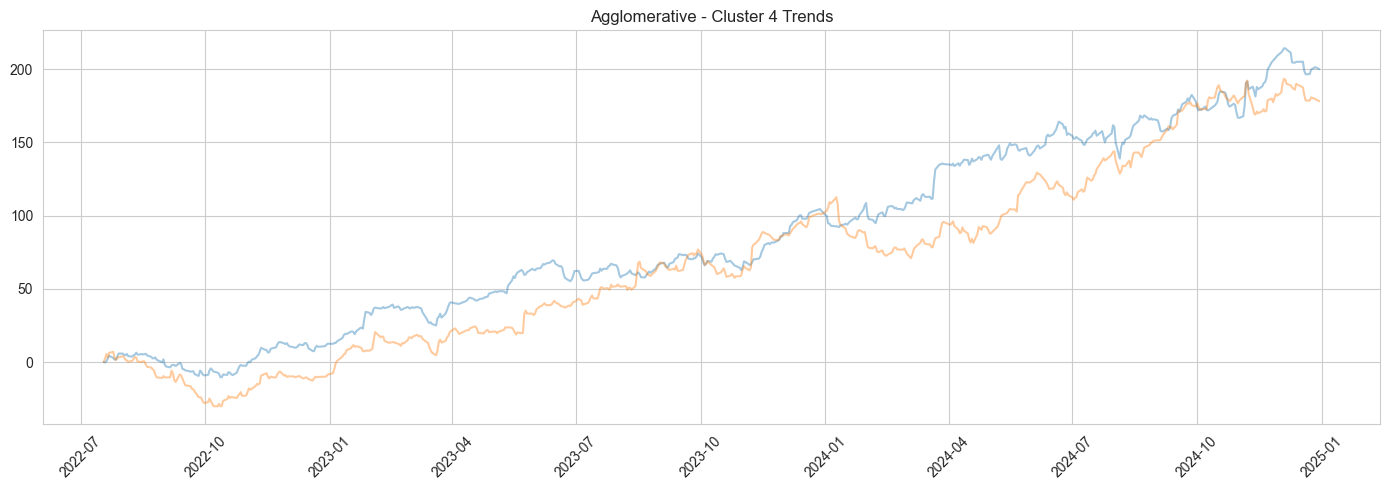

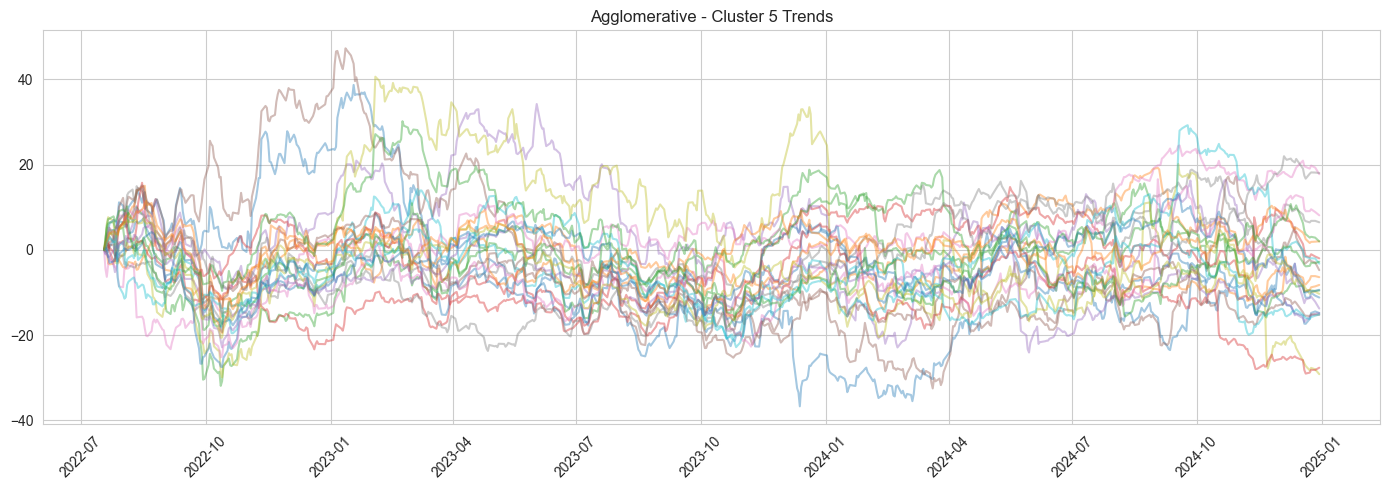

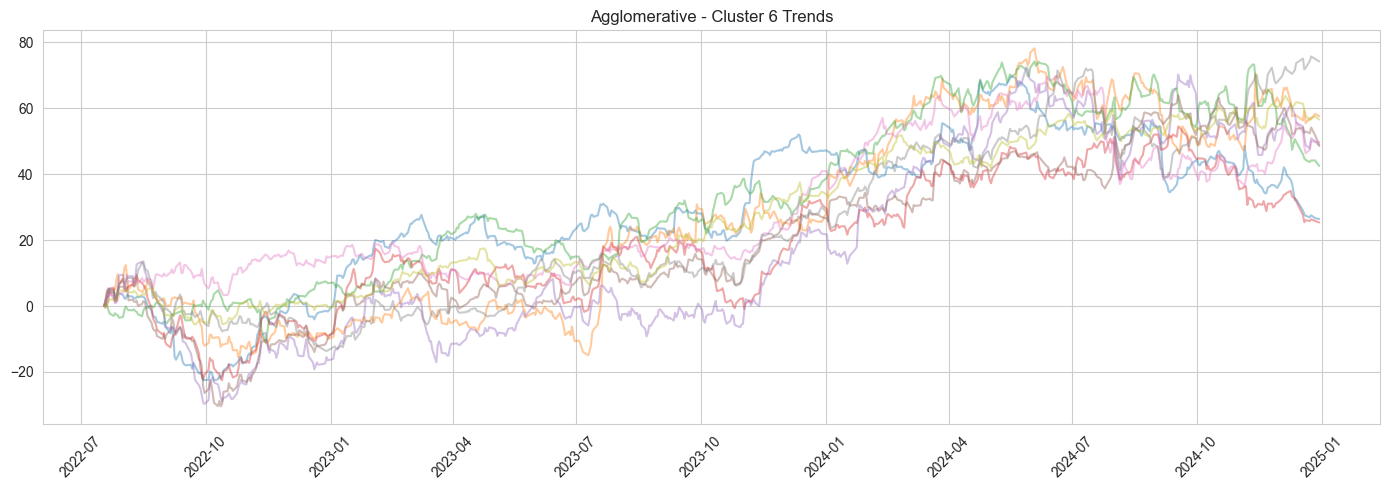

In [15]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df_pct_diff, agglo.labels_, "Agglomerative")

# GMM

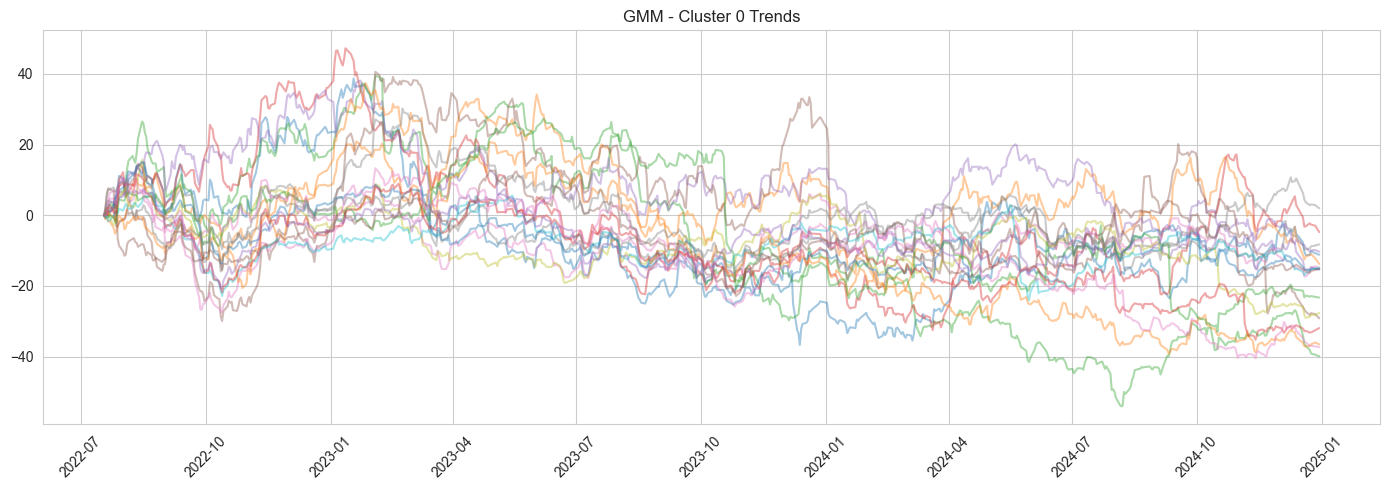

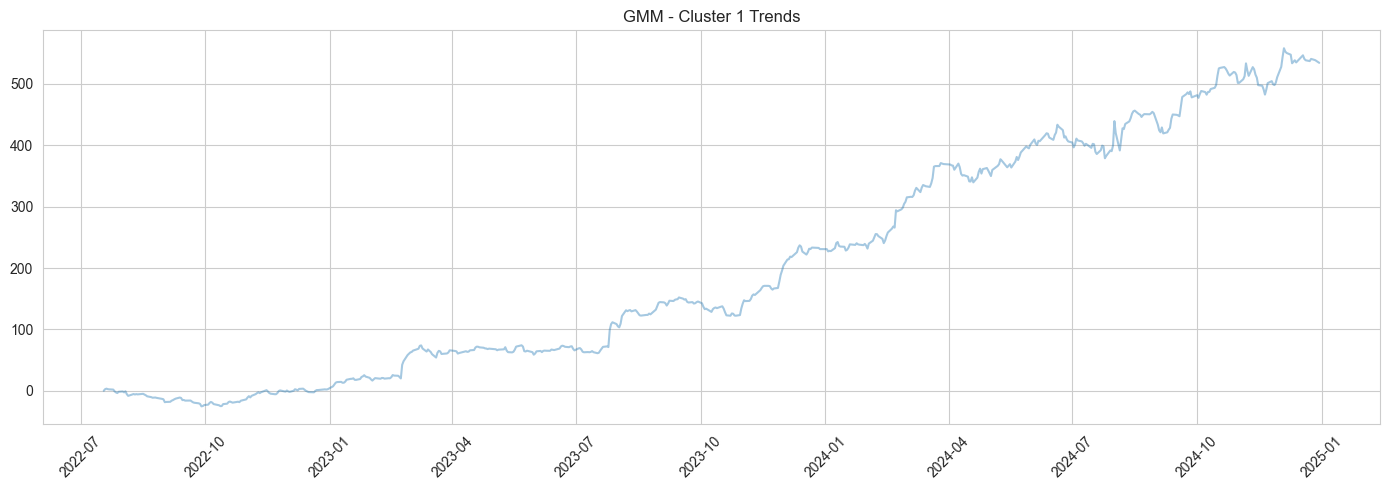

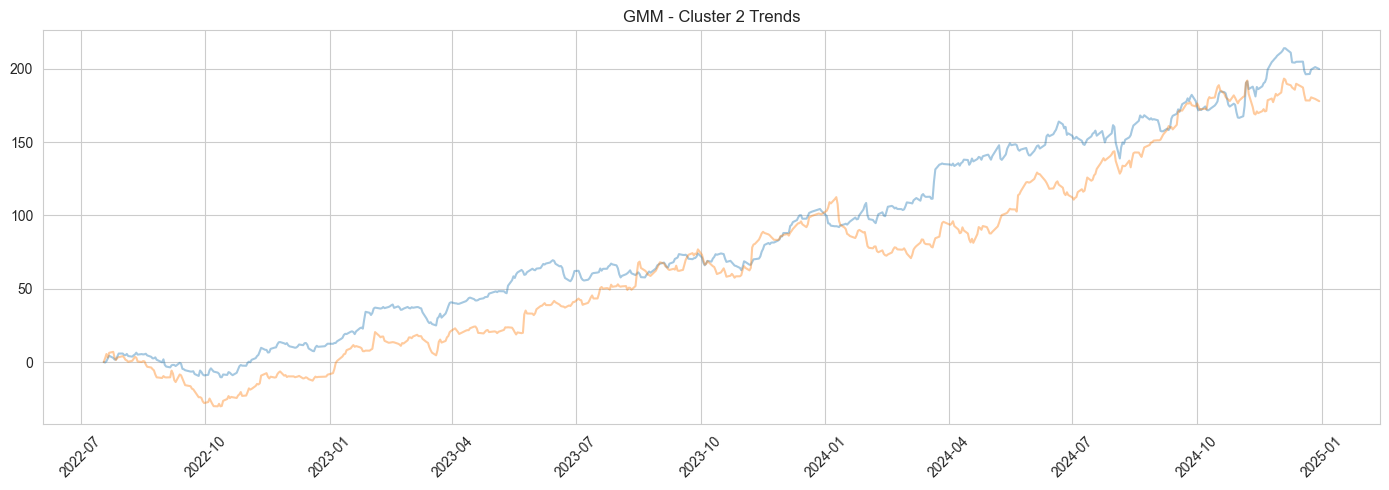

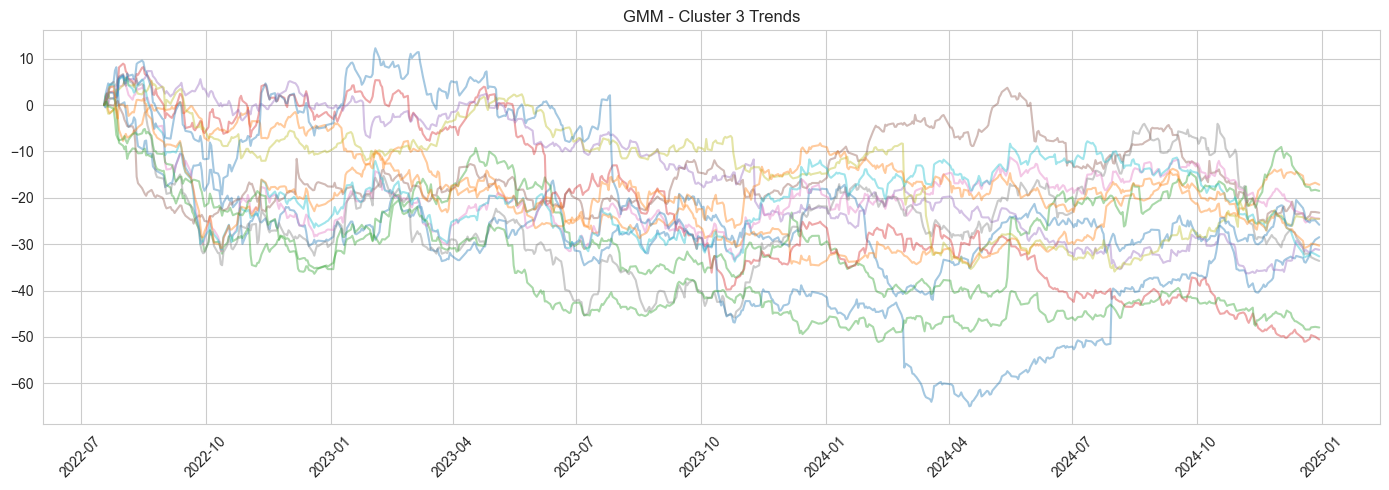

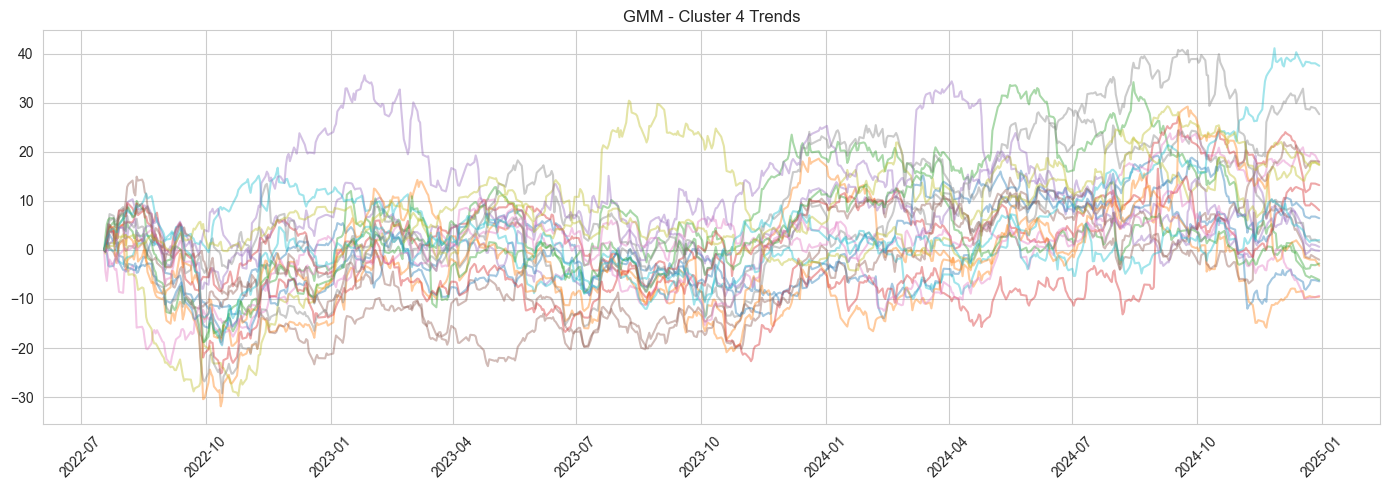

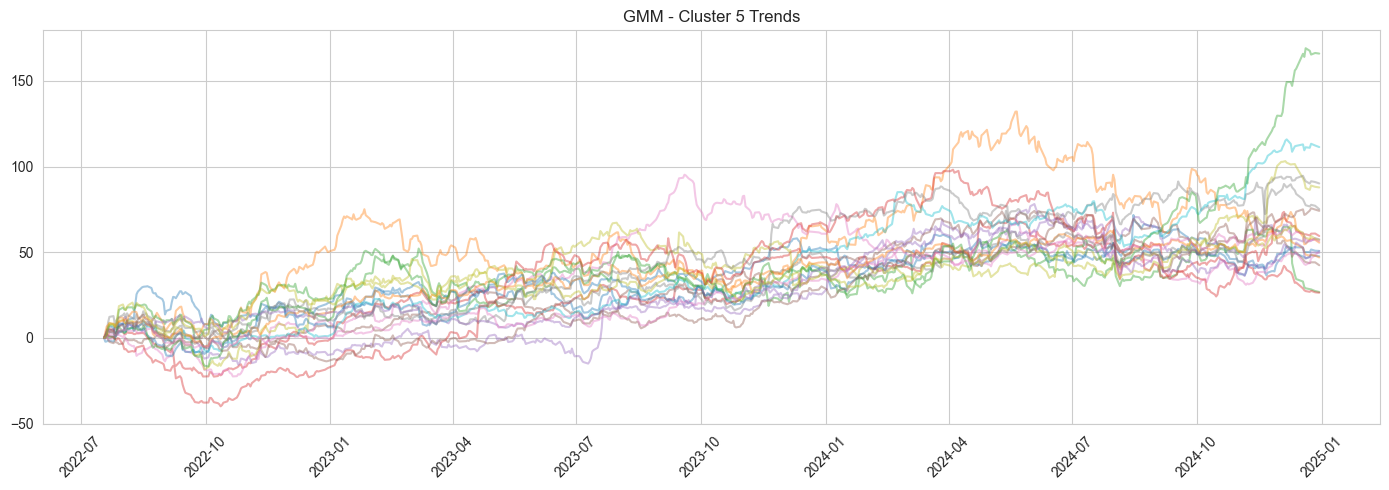

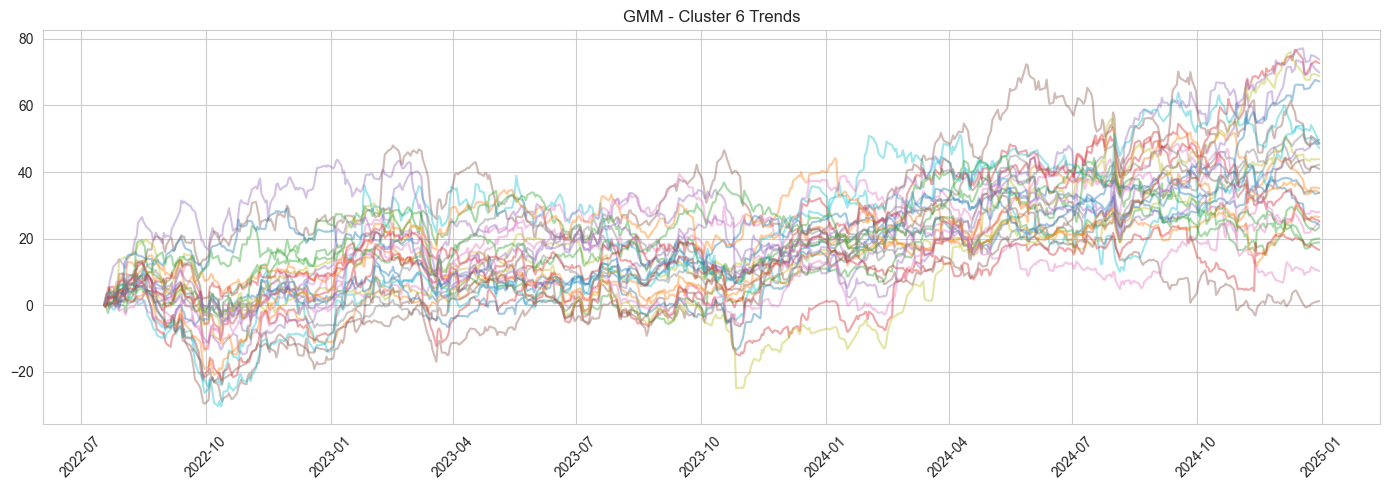

In [16]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df_pct_diff, gmm.predict(df_pct_diff), "GMM")

# Birch

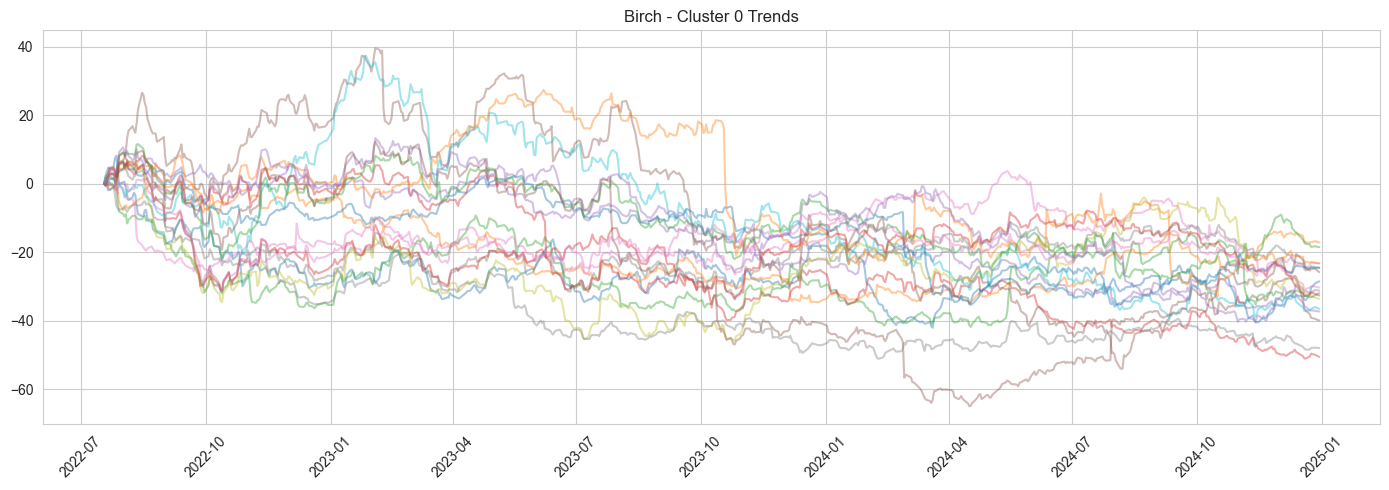

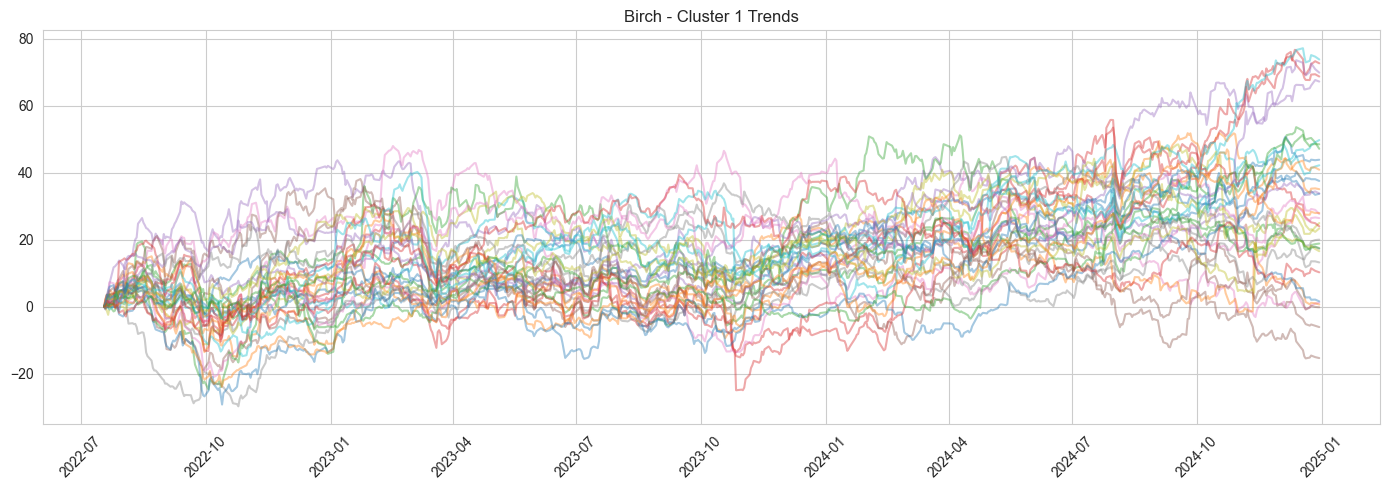

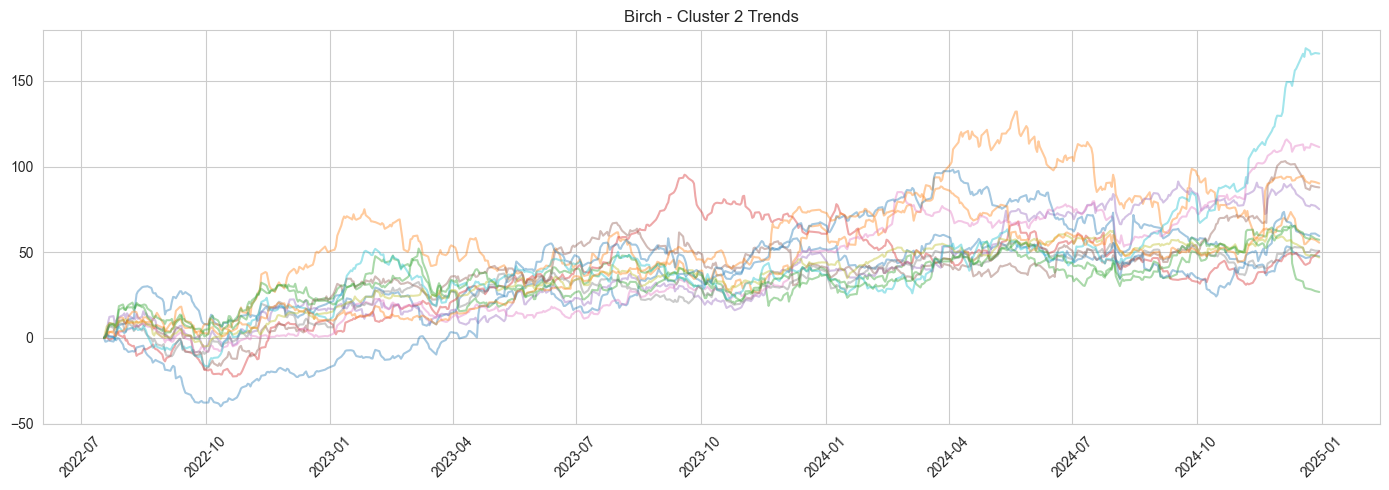

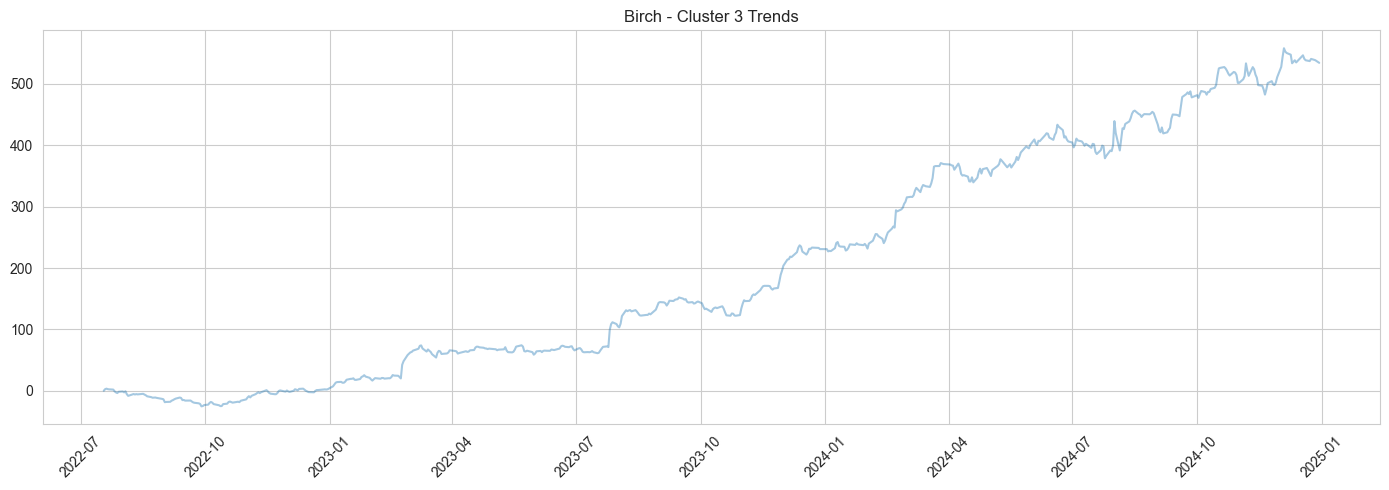

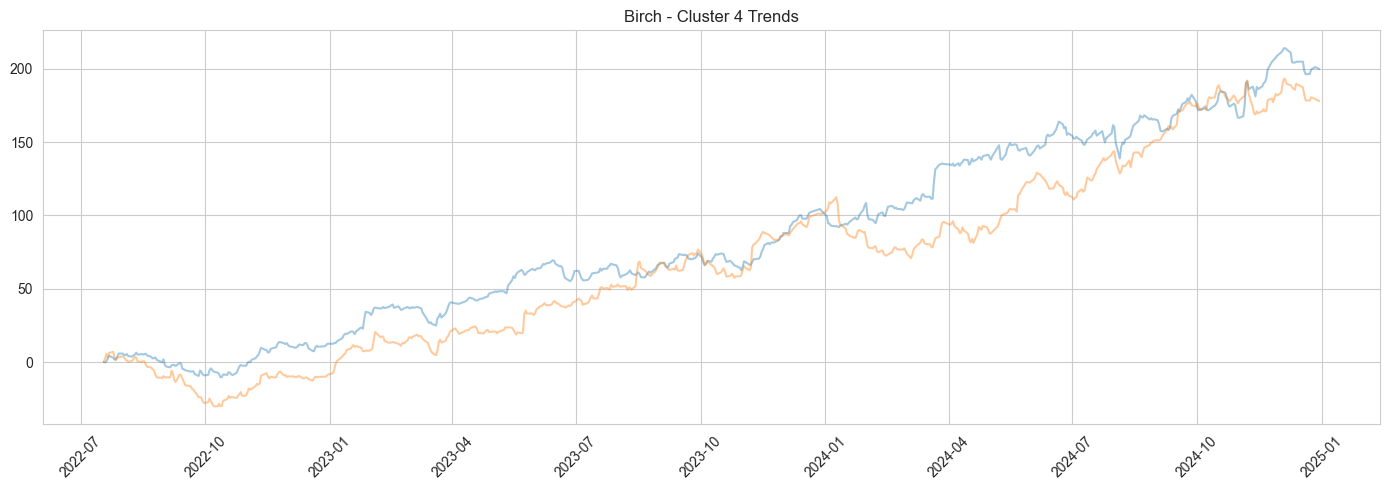

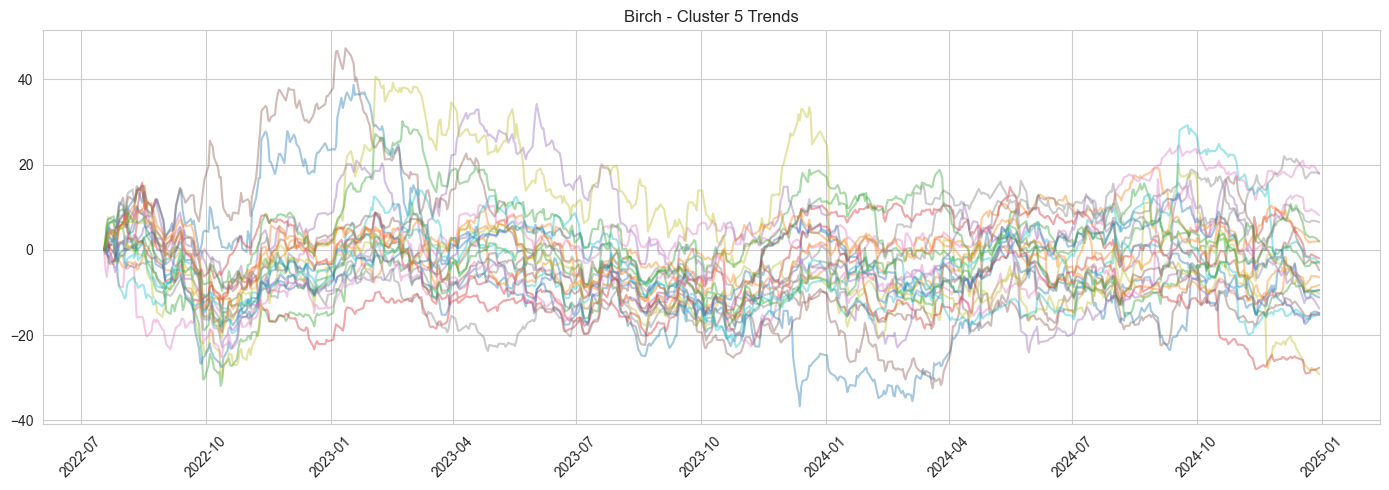

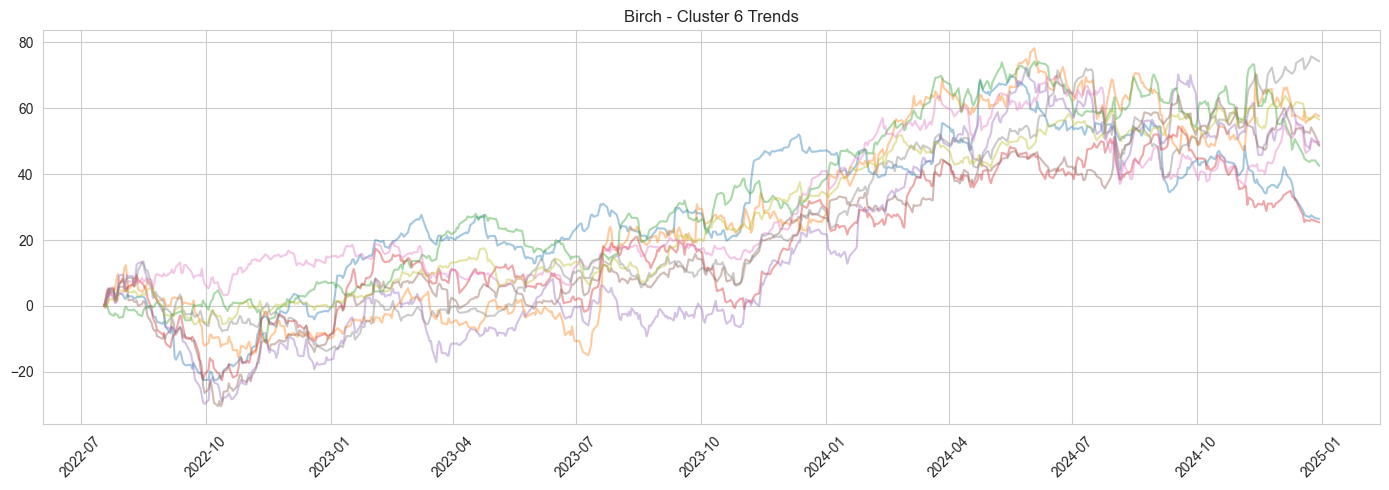

In [17]:
# Example: Visualize KMeans clusters
plot_clusters_trend(df_pct_diff, birch.labels_, "Birch")

# Cluster Visualization

In [18]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_pct_diff)

umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(df_pct_diff)

def plot_clusters_2D(X_proj, labels, method_name, reduction="t-SNE"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=labels, palette='tab10', s=30)
    plt.title(f'{method_name} Clusters Visualized with {reduction}')
    plt.grid(True)
    plt.show()

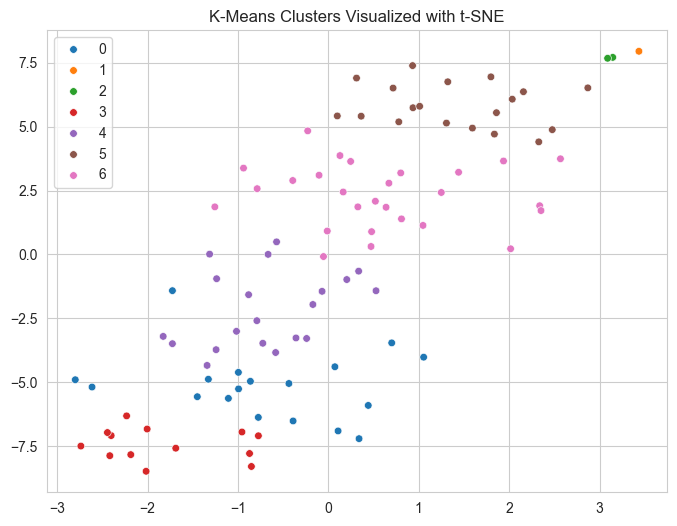

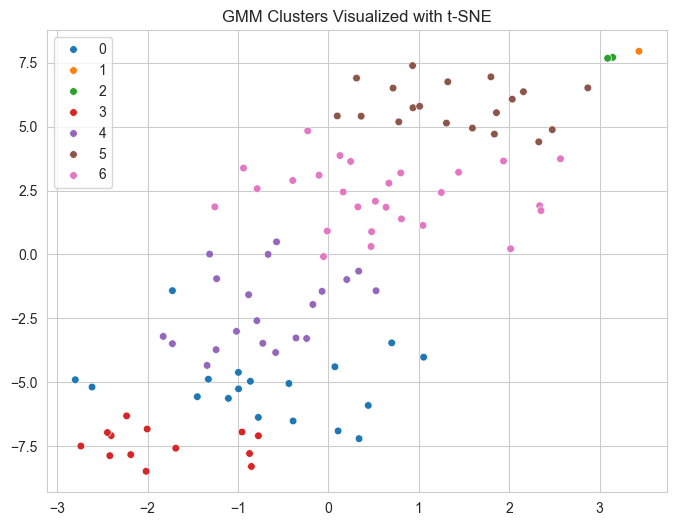

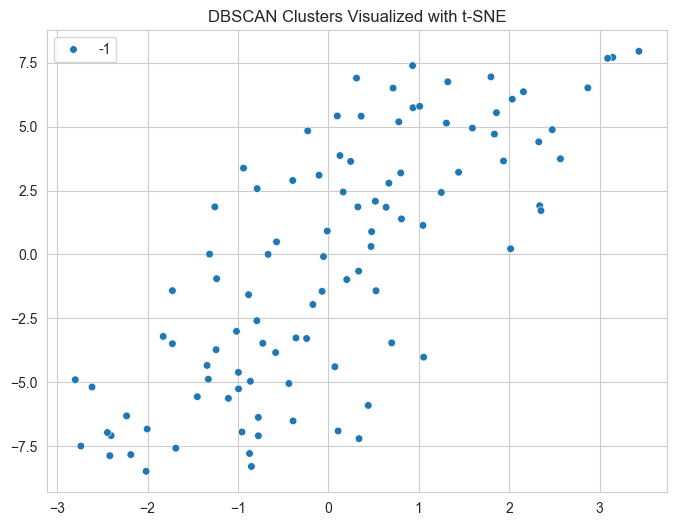

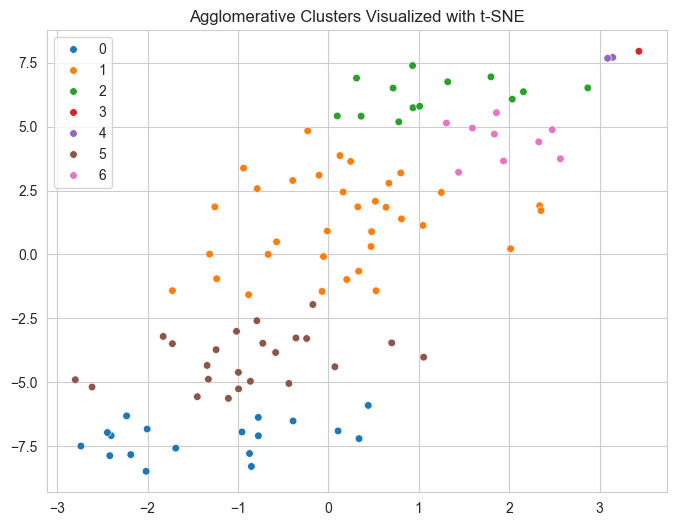

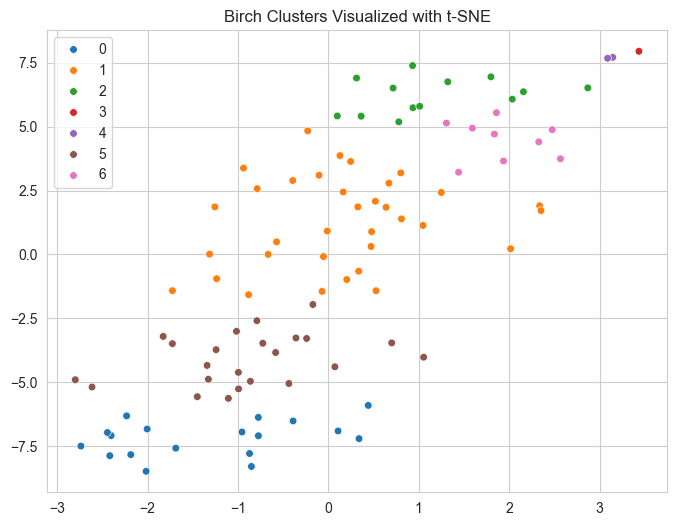

In [19]:
plot_clusters_2D(X_tsne, kmeans.labels_, "K-Means", "t-SNE")
plot_clusters_2D(X_tsne, gmm.predict(df_pct_diff), "GMM", "t-SNE")
plot_clusters_2D(X_tsne, dbscan.labels_, "DBSCAN", "t-SNE")
plot_clusters_2D(X_tsne, agglo.labels_, "Agglomerative", "t-SNE")
plot_clusters_2D(X_tsne, birch.labels_, "Birch", "t-SNE")

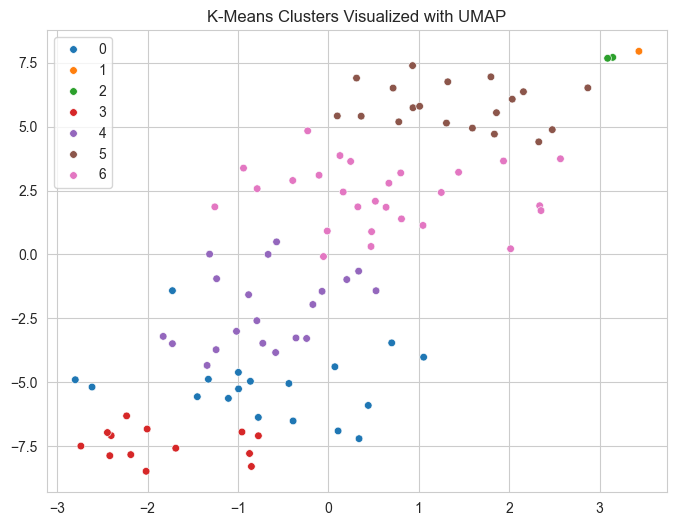

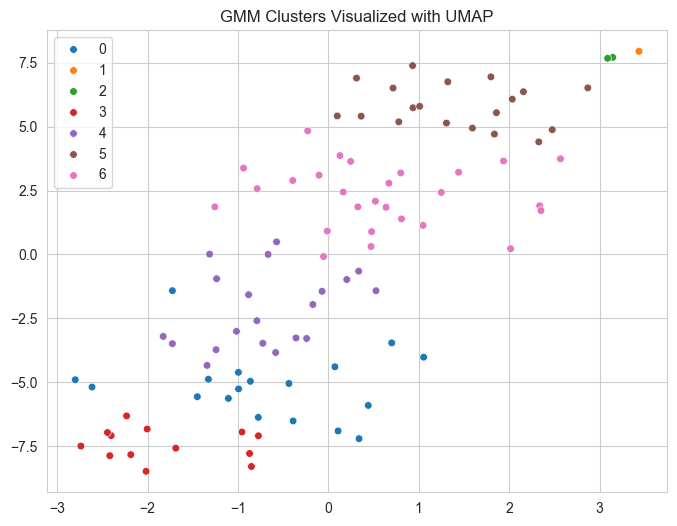

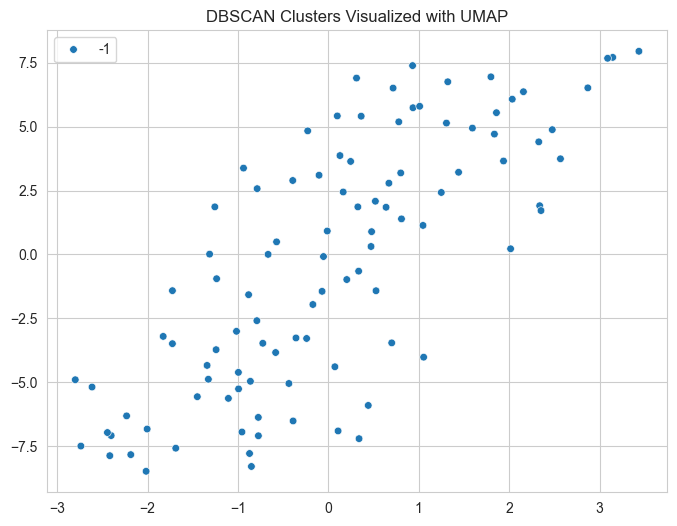

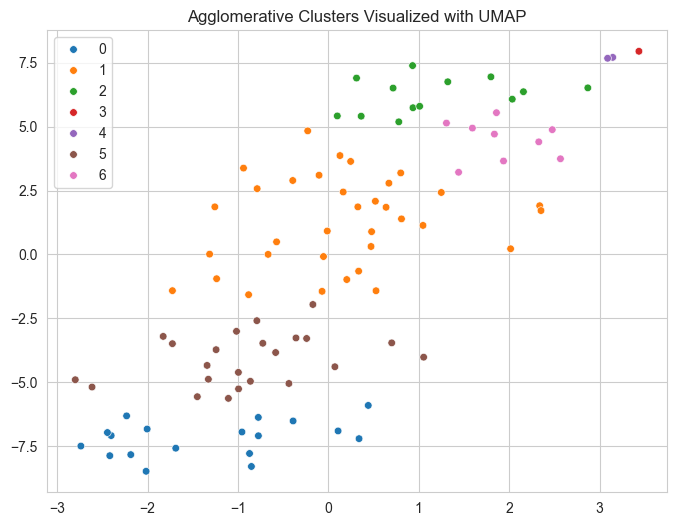

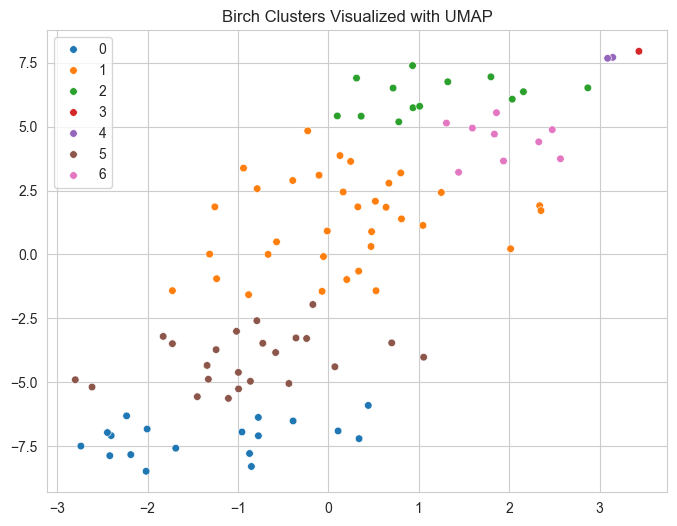

In [20]:
plot_clusters_2D(X_tsne, kmeans.labels_, "K-Means", "UMAP")
plot_clusters_2D(X_tsne, gmm.predict(df_pct_diff), "GMM", "UMAP")
plot_clusters_2D(X_tsne, dbscan.labels_, "DBSCAN", "UMAP")
plot_clusters_2D(X_tsne, agglo.labels_, "Agglomerative", "UMAP")
plot_clusters_2D(X_tsne, birch.labels_, "Birch", "UMAP")